# ERC-4626: analyse individual vaults

- In this notebook, we examine a single or handful of handpicked ERC-4626 vaults
    - Vaults are picked manually by (chain, address) list
    - We analyse the vault performance by its share price, as reported by ERC-4626 smart contract interface.    
    - We do last three months and historical all-time analyses
    - We look [quantitative finance](https://tradingstrategy.ai/glossary/quantitative-finance) aspects of the vaults like [returns](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr), [Sharpe](https://tradingstrategy.ai/glossary/sharpe) and [Sortino](https://tradingstrategy.ai/glossary/sortino) numbers    

Some notes
- Because of how vault metrics, share price and such are collected and interpreted, the results in this notebook contain various inaccuracies.
- In this notebook, we use terms Net Asset Value (NAV) and [Total Value Locked (TVL)](https://tradingstrategy.ai/glossary/total-value-locked-tvl) interchangeably.

## Usage

This is an open source notebook based on open data
- You can edit and remix this notebook yourself 

To do your own data research:

- Read general instructions [how to run the tutorials](./)
- See `ERC-4626: scanning vaults' historical price and performance` example in tutorials first how to build `vault-prices-1h.parquet` file.

For any questions, follow and contact [Trading Strategy community](https://tradingstrategy.ai/community).

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [1]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.vault.base import VaultSpec
from eth_defi.research.notebook import set_large_plotly_chart_font

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

# https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

# Set all Plotly charts to use large font sizes for better readability,
# for sharing on mobile
set_large_plotly_chart_font(line_width=5, legend_font_size=16)
pio.templates.default = "custom"

## Read and clean raw scanned vault price data

- Read the Parquet file produced earlier with price scan 
- Clean the data if necessary

In [ ]:
from pathlib import Path

from eth_defi.vault.vaultdb import VaultDatabase

data_folder = Path("~/.tradingstrategy/vaults").expanduser()


vault_db = VaultDatabase.read()

cleaned_data_parquet_file = data_folder / "cleaned-vault-prices-1h.parquet"
prices_df = pd.read_parquet(cleaned_data_parquet_file)

print(f"We have {len(vault_db):,} vaults in the database and {len(prices_df):,} price rows.")

We have 23,993 vaults in the database and 13,405,390 price rows.


## Choose vaults to examine

- We pick vaults to examine and compare by chain and address tuples

In [3]:
from eth_defi.vault.base import VaultSpec


# Historically troublesome vaults
VAULTS = [
    # USDC Fluid Lender
    VaultSpec(1, "0x00c8a649c9837523ebb406ceb17a6378ab5c74cf"),

    # Harvest USDC Autopilot on IPOR on Base
    # https://app.ipor.io/fusion/base/0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4/settings
    VaultSpec(8453, "0x0d877Dc7C8Fa3aD980DfDb18B48eC9F8768359C4"),
    
    # IPOR USDC base
    # https://app.ipor.io/fusion/base/0x45aa96f0b3188d47a1dafdbefce1db6b37f58216
    VaultSpec(8453, "0x45aa96f0b3188d47a1dafdbefce1db6b37f58216"),
    
    # gTRADE (Gains) on Polygon
    # https://app.ipor.io/fusion/base/0x45aa96f0b3188d47a1dafdbefce1db6b37f58216
    # VaultSpec(137, "0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81"),
    
    # Gains on ARbitrum
    # 42161-0xd85e038593d7a098614721eae955ec2022b9b91b
    # VaultSpec(42161, "0xd85e038593d7a098614721eae955ec2022b9b91b"),

    # gUSD on Arbitrum
    # VaultSpec(42161, "0xd3443ee1e91af28e5fb858fbd0d72a63ba8046e0"),

    # Peapods arbitrum
    # VaultSpec(42161, "0xc2810eb57526df869049fbf4c541791a3255d24c"),

    # Degen pool USDC 42161-0x20a1012b79e8f3ca3f802533c07934ef97398da
    # VaultSpec(42161, "0x20a1012b79e8f3ca3f802533c07934ef97398da7"),

    # Fluegel DAO
    # 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c
    # https://fluegelcoin.com/dashboard
    # VaultSpec(8453, "0x277a3c57f3236a7d4548576074d7c3d7046eb26c"),

    # Plutus hedge on Arbitrum
    VaultSpec(42161, "0x58BfC95a864e18E8F3041D2FCD3418f48393fE6A"),
]



## Period selection

- Choose the period we want to examine
- Comment out the trim operation if you want to examine the latest data

In [4]:

last_sample_at = prices_df.index[-1]
three_months_ago = last_sample_at - pd.DateOffset(months=3)

PERIOD = [
    three_months_ago,
    last_sample_at,
]

mask = (prices_df.index >= PERIOD[0]) & (prices_df.index <= PERIOD[1])
prices_df = prices_df[mask]
print(f"Trimmed period contains {len(prices_df):,} price rows.")

display(prices_df.head(2))

Trimmed period contains 3,144,844 price rows.


id  chain  \
timestamp                                                                  
2025-08-03 21:43:11  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-08-03 22:43:11  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   

                                                        address  block_number  \
timestamp                                                                       
2025-08-03 21:43:11  0x00000000efe883b3304aff71eacf72dbc3e1b577      23063299   
2025-08-03 22:43:11  0x00000000efe883b3304aff71eacf72dbc3e1b577      23063599   

                     share_price  total_assets  total_supply  performance_fee  \
timestamp                                                                       
2025-08-03 21:43:11         0.86 21,753,621.18 25,339,963.85              NaN   
2025-08-03 22:43:11         0.86 21,755,229.34 25,341,613.28              NaN   

                     management_fee errors                     name  \
timestamp                                                             
2025-08-03 21:43:11             NaN         Resupply Insurance Pool   
2025-08-03 22:43:11             NaN         Resupply Insurance Pool   

                     event_count            protocol  raw_share_price  \
timestamp                                                               
2025-08-03 21:43:11         1932  <unknown ERC-4626>             0.86   
2025-08-03 22:43:11         1932  <unknown ERC-4626>             0.86   

                     returns_1h  avg_assets_by_vault  dynamic_tvl_threshold  \
timestamp                                                                     
2025-08-03 21:43:11        0.00        27,648,821.34             552,976.43   
2025-08-03 22:43:11        0.00        27,648,821.34             552,976.43   

                     tvl_filtering_mask  
timestamp                                
2025-08-03 21:43:11               False  
2025-08-03 22:43:11               False

## Examine data



### Examine metadata

In [5]:
examined_vault_spec = VAULTS[0]
examined_id = f"{examined_vault_spec.chain_id}-{examined_vault_spec.vault_address}"

vault_metadata = vault_db.rows[examined_vault_spec]
display(vault_metadata)

{'Symbol': 'ysUSDC',
 'Name': 'USDC Fluid Lender',
 'Address': '0x00c8a649c9837523ebb406ceb17a6378ab5c74cf',
 'Denomination': 'USDC',
 'NAV': Decimal('11776654.127952'),
 'Protocol': 'Fluid',
 'Mgmt fee': None,
 'Perf fee': None,
 'Deposit fee': 0.0,
 'Withdraw fee': 0.0,
 'Shares': Decimal('11294152.708745'),
 'First seen': datetime.datetime(2025, 8, 20, 7, 9, 35),
 'Features': 'fluid_like',
 'Lock up': None,
 '_detection_data': ERC4262VaultDetection(chain=1, address='0x00c8a649c9837523ebb406ceb17a6378ab5c74cf', first_seen_at_block=23180703, first_seen_at=datetime.datetime(2025, 8, 20, 7, 9, 35), features={<ERC4626Feature.fluid_like: 'fluid_like'>}, updated_at=datetime.datetime(2025, 11, 4, 16, 15, 13, 610468), deposit_count=131, redeem_count=244),
 '_denomination_token': {'name': 'USD Coin',
  'symbol': 'USDC',
  'total_supply': 50846432239118565,
  'decimals': 6,
  'extra_data': {'cached': True},
  'address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
  'chain': 1},
 '_share_toke

### Examine share price/cleaned returns rows available

In [6]:
examined_vault_spec = VAULTS[0]
examined_id = f"{examined_vault_spec.chain_id}-{examined_vault_spec.vault_address}"
vault_df = prices_df[prices_df["id"] == examined_id]

vault_metadata = vault_db[examined_vault_spec]

print(f"Data for vault {examined_id}, {vault_metadata['Name']} ({vault_metadata['Symbol']}) has {len(vault_df):,} rows.")
display(vault_df.head(3))

TypeError: 'VaultDatabase' object is not subscriptable

## Vault charts and performance tearsheets

- Examine vault metrics and charts

Share price movement: 1.0000 2025-08-20 07:48:59 -> 1.0395 2025-10-21 14:01:23


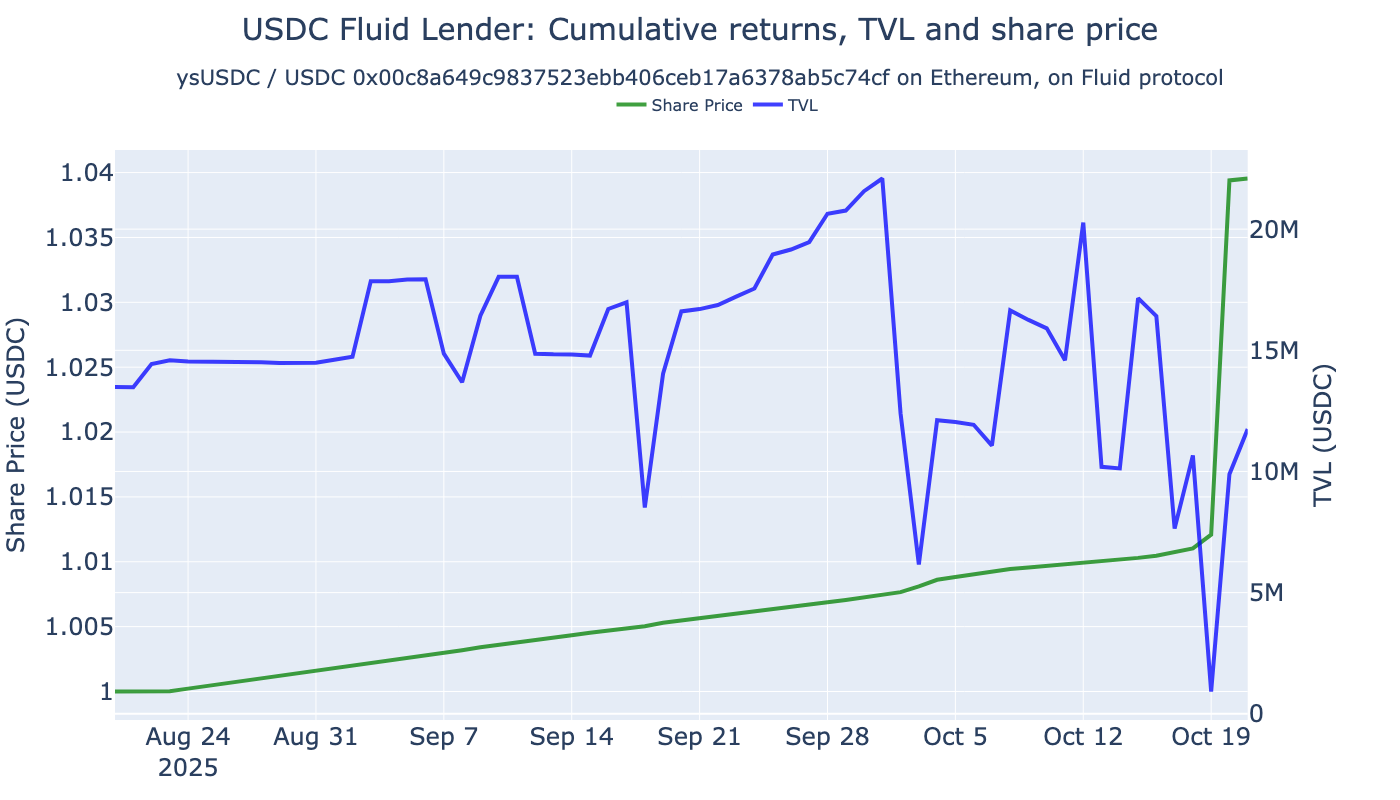

Vault               USDC Fluid Lender (Ethereum)
Last price at                2025-10-21 14:01:23
Last price                                  1.04
Block last price                      23,411,599
Month ago                    2025-09-21 14:01:23
Block month ago                       23,411,599
Month ago price                             1.01
Monthly change %                            3.38
dtype: object

Share price movement: 1.0310 2025-07-26 17:02:57 -> 1.0511 2025-10-26 16:02:57


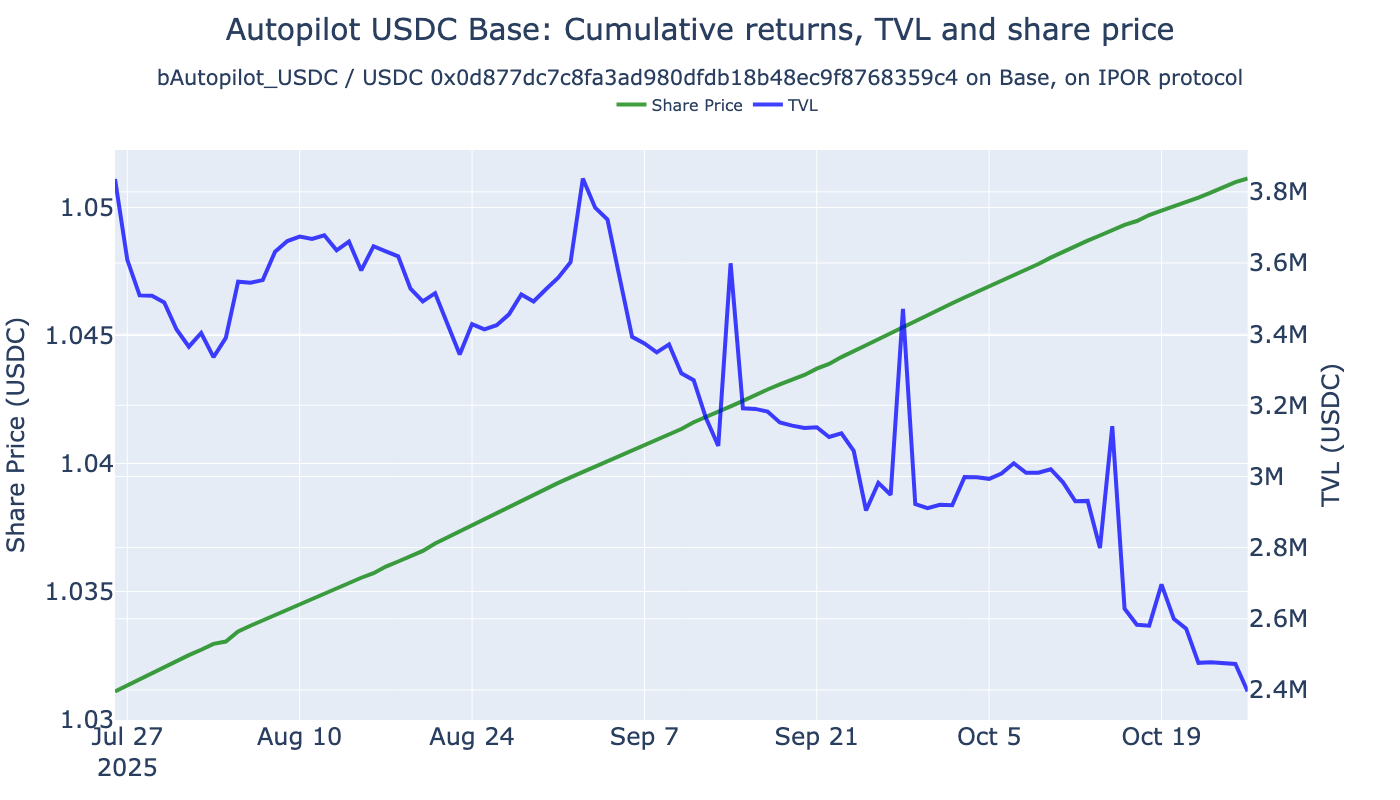

Vault               Autopilot USDC Base (Base)
Last price at              2025-10-26 16:02:57
Last price                                1.05
Block last price                    36,056,615
Month ago                  2025-09-26 16:02:57
Block month ago                     36,056,615
Month ago price                           1.04
Monthly change %                          0.61
dtype: object

Share price movement: 1.0546 2025-07-26 17:02:57 -> 1.0706 2025-10-26 16:02:57


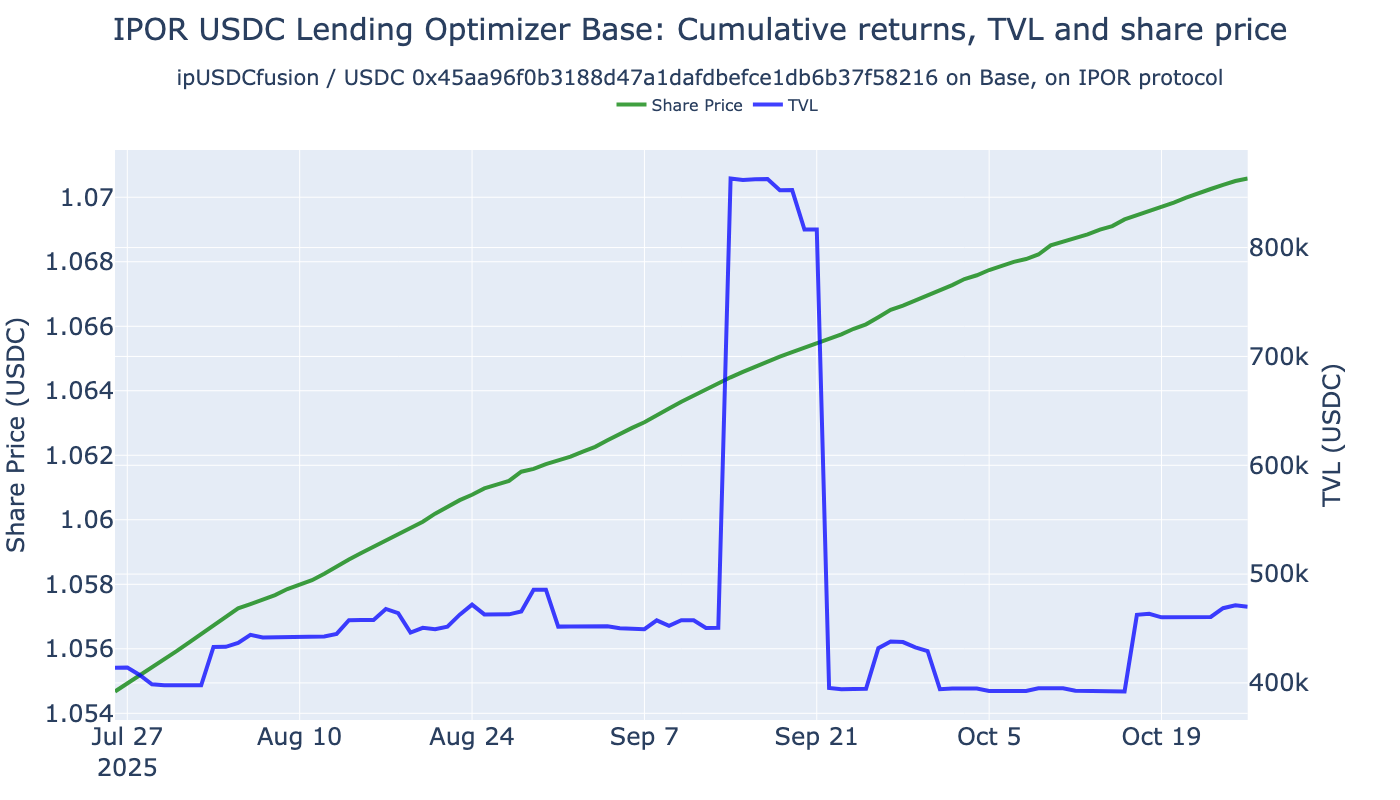

Vault               IPOR USDC Lending Optimizer Base (Base)
Last price at                           2025-10-26 16:02:57
Last price                                             1.07
Block last price                                 36,056,615
Month ago                               2025-09-26 16:02:57
Block month ago                                  36,056,615
Month ago price                                        1.07
Monthly change %                                       0.42
dtype: object

Share price movement: 1.0637 2025-07-26 16:21:44 -> 1.1589 2025-10-26 15:58:17


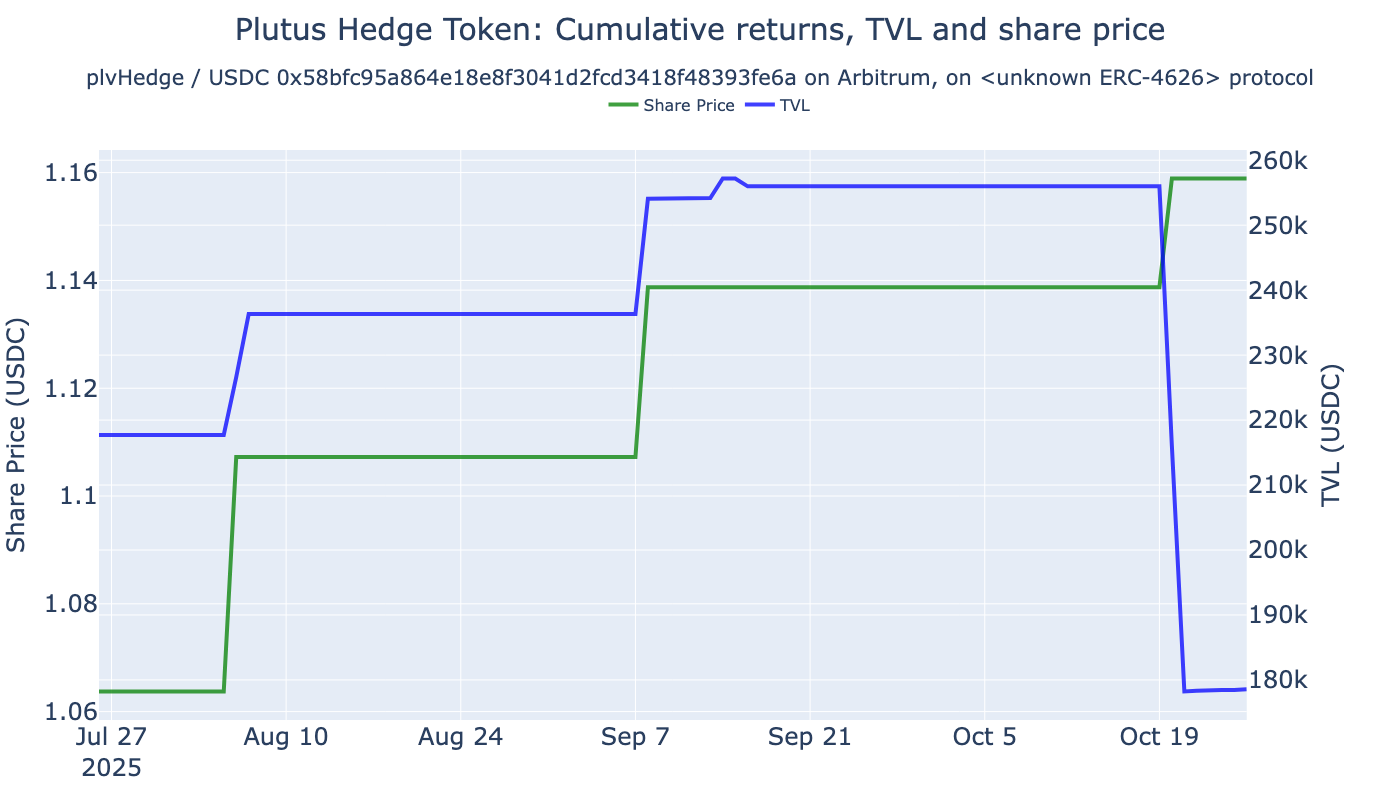

Vault               Plutus Hedge Token (Arbitrum)
Last price at                 2025-10-26 15:58:17
Last price                                   1.16
Block last price                      383,259,521
Month ago                     2025-09-26 15:58:17
Block month ago                       383,259,521
Month ago price                              1.14
Monthly change %                             1.77
dtype: object

In [ ]:
from eth_defi.research.vault_metrics import analyse_vault, format_ffn_performance_stats
from eth_defi.chain import get_chain_name

from tabulate import tabulate
from IPython.display import display, HTML

for vault_spec in VAULTS:
    vault_report = analyse_vault(
        vault_db=vault_db,
        prices_df=prices_df,
        spec=vault_spec,
        chart_frequency="daily",
    )

    chain_name = get_chain_name(vault_spec.chain_id)
    vault_name = vault_report.vault_metadata["Name"]
    display(HTML(f"<h2>Vault {vault_name} ({chain_name}): {vault_spec.vault_address})</h2><br>"))

    # Display returns figur
    returns_chart_fig = vault_report.rolling_returns_chart
    returns_chart_fig.show()

    # Check raw montly share price numbers for each vault
    hourly_price_df = vault_report.hourly_df
    last_price_at = hourly_price_df.index[-1]
    last_price = hourly_price_df["share_price"].asof(last_price_at)
    last_block = hourly_price_df["block_number"].asof(last_price_at)
    month_ago = last_price_at - pd.DateOffset(months=1)
    month_ago_price = hourly_price_df["share_price"].asof(month_ago)
    month_ago_block = hourly_price_df["block_number"].asof(month_ago)

    assert not pd.isna(month_ago_price), f"Vault {vault_spec.chain_id}-{vault_spec.vault_address}: no price data for month ago {month_ago} found, last price at {last_price_at} is {last_price}"

    data = {
        "Vault": f"{vault_name} ({chain_name})",
        "Last price at": last_price_at,
        "Last price": last_price,
        "Block last price": f"{month_ago_block:,}",
        "Month ago": month_ago,
        "Block month ago": f"{month_ago_block:,}",
        "Month ago price": month_ago_price,
        "Monthly change %": (last_price - month_ago_price) / month_ago_price * 100,
    }

    df = pd.Series(data)
    display(df)

    # Display FFN stats
    performance_stats = vault_report.performance_stats
    if performance_stats is not None:
        stats_df = format_ffn_performance_stats(performance_stats)
        # display(stats_df)
        display(HTML(stats_df.to_frame(name='Value').to_html(float_format='{:,.2f}'.format, index=True)))
    else:
        print(f"Vault {vault_spec.chain_id}-{vault_spec.vault_address}: performance metrics not available, is quantstats library installed?")

## Rolling returns comparison

- Show rolling returns of all picked vaults

id           timestamp  chain  \
0  1-0x00c8a649c9837523ebb406ceb17a6378ab5c74cf 2025-08-20 07:48:59      1   
1  1-0x00c8a649c9837523ebb406ceb17a6378ab5c74cf 2025-08-20 08:49:11      1   
2  1-0x00c8a649c9837523ebb406ceb17a6378ab5c74cf 2025-08-20 09:49:11      1   

                                      address  block_number  share_price  \
0  0x00c8a649c9837523ebb406ceb17a6378ab5c74cf      23180899         1.00   
1  0x00c8a649c9837523ebb406ceb17a6378ab5c74cf      23181199         1.00   
2  0x00c8a649c9837523ebb406ceb17a6378ab5c74cf      23181499         1.00   

   total_assets  total_supply  performance_fee  management_fee errors  \
0  7,786,726.95  7,786,726.95              NaN             NaN          
1  7,786,770.34  7,786,769.96              NaN             NaN          
2 11,574,091.76 11,574,090.61              NaN             NaN          

                                  name  event_count protocol  raw_share_price  \
0  USDC Fluid Lender (Ethereum) #11057          356    Fluid             1.00   
1  USDC Fluid Lender (Ethereum) #11057          356    Fluid             1.00   
2  USDC Fluid Lender (Ethereum) #11057          356    Fluid             1.00   

   returns_1h  avg_assets_by_vault  dynamic_tvl_threshold  tvl_filtering_mask  \
0         NaN        15,015,907.69             300,318.15               False   
1        0.00        15,015,907.69             300,318.15               False   
2        0.00        15,015,907.69             300,318.15               False   

   rolling_1m_returns  
0                0.00  
1                0.00  
2                0.00

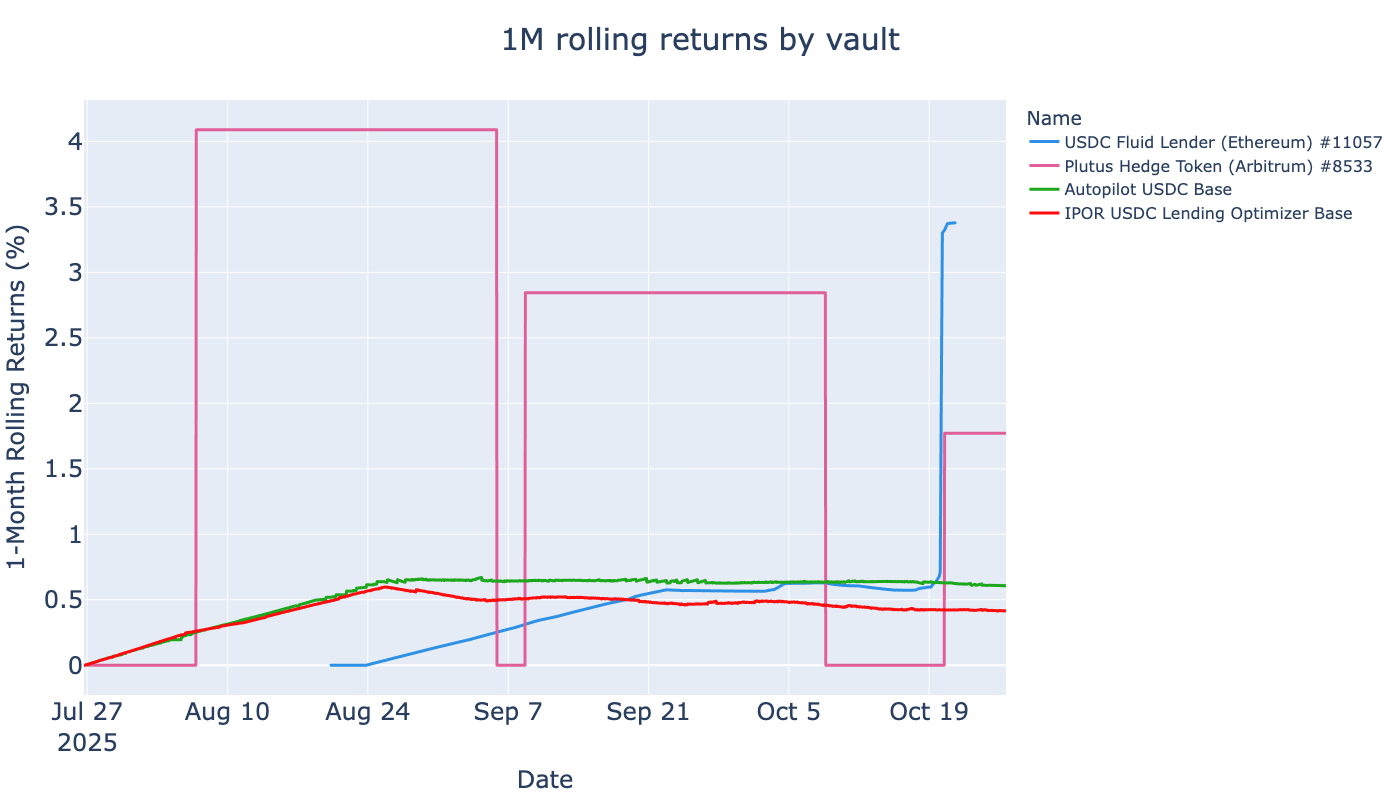

In [ ]:
from eth_defi.research.rolling_returns import calculate_rolling_returns, visualise_rolling_returns

interesting_vaults = [spec.as_string_id() for spec in VAULTS]

rolling_returns_df = calculate_rolling_returns(
    prices_df,
    interesting_vaults=interesting_vaults,
    clip_up=100,
)

display(rolling_returns_df.head(3))

fig = visualise_rolling_returns(rolling_returns_df)

fig.show()

## Raw vault data

- Examine raw data of a single vault
- Find abnormal return rows

In [ ]:
# Fluegel DAO
# 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c
# https://fluegelcoin.com/dashboard
vault_spec = VaultSpec(8453, "0x277a3c57f3236a7d4548576074d7c3d7046eb26c")

df = prices_df[prices_df["id"] == vault_spec.as_string_id()]

# 10% claimed hourly returns
mask = df["returns_1h"].abs() > 0.10
expanded_mask = (mask | mask.shift(1) | mask.shift(-1)).fillna(False)

df = df[expanded_mask]  # Filter out rows with small returns

display(df.head(10))

id  chain  \
timestamp                                                                     
2025-08-03 10:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-08-03 11:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-08-03 12:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-08-13 21:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-08-13 22:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-08-13 23:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-10-09 04:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-10-09 05:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-10-09 06:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   
2025-10-10 21:02:57  8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c   8453   

                                                        address  block_number  \
timestamp                                                                       
2025-08-03 10:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      33713015   
2025-08-03 11:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      33714815   
2025-08-03 12:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      33716615   
2025-08-13 21:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      34164815   
2025-08-13 22:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      34166615   
2025-08-13 23:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      34168415   
2025-10-09 04:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      36596615   
2025-10-09 05:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      36598415   
2025-10-09 06:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      36600215   
2025-10-10 21:02:57  0x277a3c57f3236a7d4548576074d7c3d7046eb26c      36670415   

                     share_price  total_assets  total_supply  performance_fee  \
timestamp                                                                       
2025-08-03 10:02:57         2.15    695,567.33    323,616.44              NaN   
2025-08-03 11:02:57         1.85    597,383.18    323,616.44              NaN   
2025-08-03 12:02:57         1.95    632,163.53    323,616.44              NaN   
2025-08-13 21:02:57         1.99    645,035.90    323,616.44              NaN   
2025-08-13 22:02:57         2.46    797,495.70    323,616.44              NaN   
2025-08-13 23:02:57         2.50    810,079.56    323,616.44              NaN   
2025-10-09 04:02:57         2.19    707,328.27    323,616.44              NaN   
2025-10-09 05:02:57         2.44    789,763.60    323,616.44              NaN   
2025-10-09 06:02:57         2.44    789,152.21    323,616.44              NaN   
2025-10-10 21:02:57         2.18    705,252.95    323,616.44              NaN   

                     management_fee errors                     name  \
timestamp                                                             
2025-08-03 10:02:57             NaN         Fluegel DAO (Base) #242   
2025-08-03 11:02:57             NaN         Fluegel DAO (Base) #242   
2025-08-03 12:02:57             NaN         Fluegel DAO (Base) #242   
2025-08-13 21:02:57             NaN         Fluegel DAO (Base) #242   
2025-08-13 22:02:57             NaN         Fluegel DAO (Base) #242   
2025-08-13 23:02:57             NaN         Fluegel DAO (Base) #242   
2025-10-09 04:02:57             NaN         Fluegel DAO (Base) #242   
2025-10-09 05:02:57             NaN         Fluegel DAO (Base) #242   
2025-10-09 06:02:57             NaN         Fluegel DAO (Base) #242   
2025-10-10 21:02:57             NaN         Fluegel DAO (Base) #242   

                     event_count            protocol  raw_share_price  \
timestamp                                                               
2025-08-03 10:02:57          185  <unknown ERC-4626>             2.15   
2025-08-03 11:02:57          185  <unknown ERC-4626>             1.85   
2025-08-03 12:02:57       